## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [86]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [190]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [191]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [192]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [193]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
drwxr-xr-x   10 gganesan  staff    340 May  2 17:42 ../../Data/Weather/US_Weather_BBBSBBBB.parquet
drwxr-xr-x   10 gganesan  staff    340 May 10 11:24 ../../Data/Weather/US_Weather_SBSSBBBS.parquet
drwxr-xr-x  404 gganesan  staff  13736 May  2 17:42 ../../Data/Weather/decon_BBBSBBBB.parquet
drwxr-xr-x  404 gganesan  staff  13736 May  2 17:42 ../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
drwxr-xr-x  404 gganesan  staff  13736 May  2 17:42 ../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
drwxr-xr-x  404 gganesan  staff  13736 May 14 20:10 ../../Data/Weather/decon_SBSSBBBS_PRCP.parquet
drwxr-xr-x  404 gganesan  staff  13736 May 14 20:22 ../../Data/Weather/decon_SBSSBBBS_SNWD.parquet
502
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+-------------------

In [194]:
#extract longitude and latitude for each station
feature='res_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, elevation, vector, %s FROM weather where measurement='SNWD'"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, elevation, vector, res_1 FROM weather where measurement='SNWD'
+-----------+---------+--------------------+-------------------+
|    station|elevation|              vector|              res_1|
+-----------+---------+--------------------+-------------------+
|USC00102260|   1797.4|[C2 61 F4 61 F4 6...|0.08489938379981538|
|USC00104845|   1795.3|[C2 61 C2 61 26 6...| 0.0468345183922323|
|USC00104845|   1795.3|[C4 60 5E 60 2A 6...| 0.0788674615367685|
|USC00104230|   2025.1|[8E 61 F4 61 F4 6...|0.05684415885304421|
+-----------+---------+--------------------+-------------------+
only showing top 4 rows



In [195]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

AnalysisException: u"cannot resolve '`latitude`' given input columns: [station, elevation, vector, res_1];;\n'Aggregate [station#509, 'latitude, 'longitude, elevation#500], [station#509, 'latitude, 'longitude, elevation#500, avg(res_1#505) AS avg(res_1)#593, count(station#509) AS count(station)#594L]\n+- Project [station#509, elevation#500, vector#512, res_1#505]\n   +- Filter (measurement#504 = SNWD)\n      +- SubqueryAlias weather, `weather`\n         +- Relation[coeff_1#497,coeff_2#498,coeff_3#499,elevation#500,label#501,latitude#502,longitude#503,measurement#504,res_1#505,res_2#506,res_3#507,res_mean#508,station#509,total_var#510,undefs#511L,vector#512,year#513] parquet\n"

In [ ]:
print pdf



In [184]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#ff3400'

## Map

In [185]:
min_lat,max_lat,min_long,max_long = box = (40.1103, 44.5133, -115.0128, -110.1125)


In [186]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
colors_arr = []
coeff = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(600*np.sqrt(_count+0.0)), weight=1,
            color=get_color(_coef), opacity=0.8, fill_opacity=0.5,
            fill_color=get_color(_coef))
    circles.append(c)
    colors_arr.append([_coef, get_color(_coef)])
    coeff.append(_coef)
    m.add_layer(c)
m    



### exercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

(1, 41)
[[ -568.68552967  -464.78325885  -293.66826309  -281.15052847
   -220.10632386  -205.68671312  -155.96217465  -114.71200772  -114.2452296
   -107.98498065  -106.24027542   -88.56308151   -88.08653427
    -74.16383285   -70.67955448   -48.47562538   -44.87685193
    -38.88993799   -34.29004616    11.22514237    56.750105      79.81055624
    101.48106916   106.24478503   113.42917991   122.55742423
    137.59487543   162.86498612   171.42519931   192.52329301
    200.48275029   204.30650462   205.3527141    223.1766242    247.91123418
    282.96037936   318.44846949   325.74496494   362.61880837
    418.85967925  1268.11372308]]


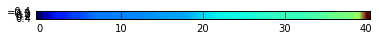

In [187]:
#Adding a legend that relates the colors to values
a = pdf.loc[:,'avg(coeff_2)'].tolist()
a.sort(key=lambda x: float(x))
a = np.matrix(a)
print a.shape
print a[0]
plt.imshow(a*10)
plt.show()





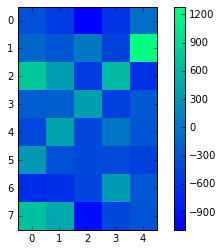

In [117]:
#Heat map of the coefficients
fig,ax = plt.subplots()
_map = np.asarray(coeff[:-1])
_map = np.reshape(_map,(8,5))
heatmap = ax.imshow(_map, cmap='winter', interpolation='nearest')
legend = fig.colorbar(heatmap)
plt.show()


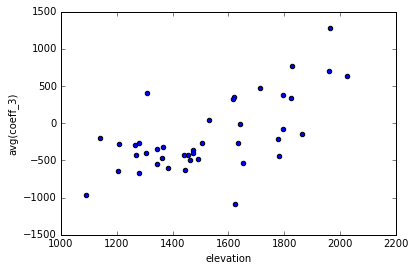

In [118]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

In [14]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']